In [3]:
from google.colab import drive
drive.mount('gdrive')
%cd gdrive/My\ Drive/colab

Mounted at gdrive
/content/gdrive/My Drive/colab


In [0]:
%matplotlib inline

In [5]:
import numpy as np
import random
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Concatenate
from keras import optimizers
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras import backend as K
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from matplotlib import pyplot as plt
import math

Using TensorFlow backend.


In [0]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [0]:
num_classes = 10
epochs = 100


In [0]:
def euclidean_distance(vects):
    x,y = vects
    sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [0]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1-y_true) * margin_square)


In [0]:
def create_pairs(x, digit_indices):
    
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]] # positive sample
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i] # negative sample
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


In [0]:
def create_pairs_per_class(x, digit_indices, class_1, class_2):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for i in range(n):
        z1, z2 = digit_indices[class_1][i], digit_indices[class_1][i + 1]
        pairs += [[x[z1], x[z2]]] # positive sample
        z1, z2 = digit_indices[class_1][i], digit_indices[class_2][i] # negative sample
        pairs += [[x[z1], x[z2]]]
        labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [0]:
# def create_base_network(input_shape):
#     '''Base network to be shared (eq. to feature extraction).
#     '''
#     input = Input(shape=input_shape)
#     x = Flatten()(input)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='relu')(x)
#     return Model(input, x)
  

In [0]:
def fire_module(x, s1x1, e1x1, e3x3, name):
    #Squeeze layer
    squeeze = Conv2D(s1x1, (1, 1), activation='relu', padding='valid', kernel_initializer='glorot_uniform', name = name + 's1x1')(x)
    squeeze_bn = BatchNormalization(name=name+'sbn')(squeeze)
    
    #Expand 1x1 layer and 3x3 layer are parallel

    #Expand 1x1 layer
    expand1x1 = Conv2D(e1x1, (1, 1), activation='relu', padding='valid', kernel_initializer='glorot_uniform', name = name + 'e1x1')(squeeze_bn)
    
    #Expand 3x3 layer
    expand3x3 = Conv2D(e3x3, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform', name = name +  'e3x3')(squeeze_bn)
    
    #Concatenate expand1x1 and expand 3x3 at filters
    output = Concatenate(axis = 3, name=name)([expand1x1, expand3x3])
    
    return output
  
def SqueezeNet(input_shape):
    inputs = Input(shape=input_shape)
    conv1 = Conv2D(96, kernel_size=(3, 3), strides=(2, 2),  padding='same', activation='relu', name = 'Conv1')(inputs)
    maxpool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='Maxpool1')(conv1)
    batch1 = BatchNormalization(name='Batch1')(maxpool1)
#     fire2 = fire_module(batch1, 16, 64, 64, "Fire2")
#     fire3 = fire_module(fire2, 16, 64, 64, "Fire3")
    fire4 = fire_module(batch1, 32, 128, 128, "Fire2")
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='Maxpool2')(fire4)
#     fire5 = fire_module(maxpool4, 32, 128, 128, "Fire5")
    fire6 = fire_module(maxpool4, 48, 192, 192, "Fire3")
    fire7 = fire_module(fire6, 48, 192, 192, "Fire4")
    fire8 = fire_module(fire7, 48, 192, 192, "Fire5")
    maxpool8 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='Maxpool5')(fire8)
#     fire9 = fire_module(maxpool8, 64, 256, 256, "Fire9")
    dropout = Dropout(0.5, name="Dropout")(maxpool8)
    conv10 = Conv2D(10, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu', name='Conv6')(dropout)
    batch10 = BatchNormalization(name='Batch6')(conv10)
    avgpool10 = GlobalAveragePooling2D(name='GlobalAvgPool6')(batch10)
    #softmax = Activation('softmax')(avgpool10)
    
    squeezenet = Model(inputs=inputs, outputs=avgpool10)
    return squeezenet
  
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    return SqueezeNet(input_shape)

In [0]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


In [0]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [16]:
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]
print(input_shape)

170500096/170498071 [==============================] - 16s 0us/step
(32, 32, 3)


In [0]:
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [18]:
print("Shape of training pairs", tr_pairs.shape)
print("Shape of training labels", tr_y.shape)

Shape of training pairs (99980, 2, 32, 32, 3)
Shape of training labels (99980,)


In [0]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape, name='input_a')
input_b = Input(shape=input_shape, name='input_b')

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


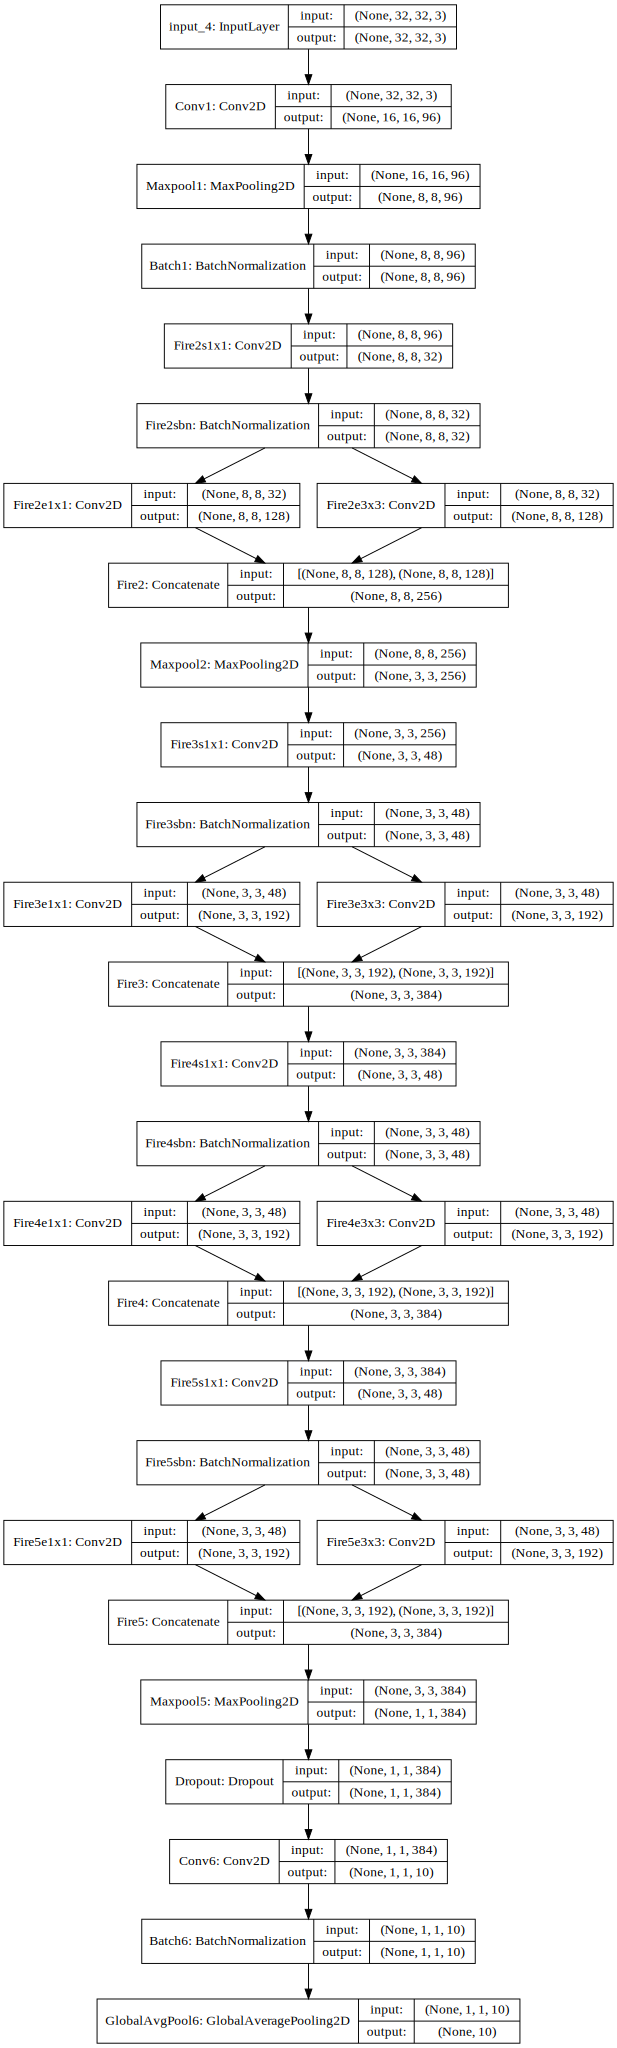

In [90]:
SVG(model_to_dot(base_network, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [91]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_a (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
input_b (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 10)           378914      input_a[0][0]                    
                                                                 input_b[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 1)            0           model_7[1][0]                    
          

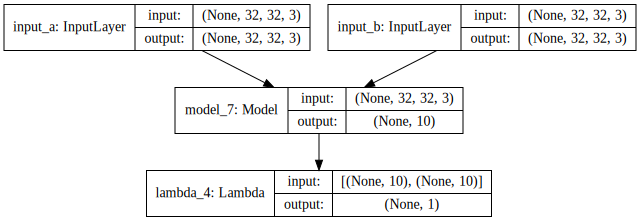

In [92]:
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
checkpointer = ModelCheckpoint(
          filepath='model.hfs5',
          save_best_only=True)
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y),
          callbacks=[checkpointer])

Train on 99980 samples, validate on 19980 samples
Epoch 1/100
99980/99980 [==============================] - 80s 803us/step - loss: 1.6321 - accuracy: 0.5755 - val_loss: 0.2843 - val_accuracy: 0.6633
Epoch 2/100
99980/99980 [==============================] - 73s 728us/step - loss: 0.2061 - accuracy: 0.6931 - val_loss: 0.2126 - val_accuracy: 0.6913
Epoch 3/100
99980/99980 [==============================] - 68s 685us/step - loss: 0.1836 - accuracy: 0.7291 - val_loss: 0.2188 - val_accuracy: 0.6643
Epoch 4/100
99980/99980 [==============================] - 68s 682us/step - loss: 0.1685 - accuracy: 0.7551 - val_loss: 0.2227 - val_accuracy: 0.6584
Epoch 5/100
99980/99980 [==============================] - 65s 645us/step - loss: 0.1573 - accuracy: 0.7739 - val_loss: 0.1976 - val_accuracy: 0.7075
Epoch 6/100
99980/99980 [==============================] - 65s 646us/step - loss: 0.1481 - accuracy: 0.7898 - val_loss: 0.1800 - val_accuracy: 0.7320
Epoch 7/100
99980/99980 [=========================

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)


In [0]:
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))


In [0]:
model.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_y)

In [19]:
model = load_model('model.hfs5', custom_objects={'contrastive_loss':contrastive_loss})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [20]:
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
for i in range(num_classes):
  for j in range(num_classes):
    print(i, j)
    te_pairs, te_y = create_pairs_per_class(x_test, digit_indices, i, j)
    result = model.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_y)
    print(result)

0 0
1998/1998 [==============================] - 3s 1ms/step
[0.6098738317494398, 0.6516516515919873]
0 1
1998/1998 [==============================] - 0s 233us/step
[0.1338126017852827, 0.18668668670160277]
0 2
1998/1998 [==============================] - 0s 232us/step
[0.18874192716660085, 0.24424424425916033]
0 3
1998/1998 [==============================] - 0s 218us/step
[0.14309392945544497, 0.19319319320810927]
0 4
1998/1998 [==============================] - 0s 222us/step
[0.15148392189909388, 0.19969969974444793]
0 5
1998/1998 [==============================] - 0s 216us/step
[0.13192575809744386, 0.1746746747194229]
0 6
1998/1998 [==============================] - 0s 222us/step
[0.1384023660057419, 0.1716716717164199]
0 7
1998/1998 [==============================] - 0s 216us/step
[0.12515759341291957, 0.1676676677124159]
0 8
1998/1998 [==============================] - 0s 218us/step
[0.25447636953106634, 0.3993993993993994]
0 9
1998/1998 [==============================] - 0s 216u